In [1]:
!pip install xgboost


In [72]:
import sklearn
print(sklearn.__version__)


1.5.1


In [95]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


# Step 1: Load the merged dataset (with prices)
df = pd.read_csv("cleaned_data.csv")

# Step 2: Aggregate cost per procedure (total cost per case)
procedure_cost = df.groupby(['procedure_id', 'procedure_name']).agg({
    'material_price': 'sum',
    'material_id': 'count',
    'surgeon_name': 'first',  # optional
    'specialty': 'first'
}).reset_index().rename(columns={'material_id': 'material_count', 'material_price': 'total_cost'})

# Step 3: Encode categorical variables
cat_cols = ['procedure_name', 'surgeon_name', 'specialty']
procedure_cost[cat_cols] = procedure_cost[cat_cols].fillna('unknown')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_cat = encoder.fit_transform(procedure_cost[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(cat_cols))

# Combine with numerical features
X = pd.concat([X_cat_df, procedure_cost[['material_count']].reset_index(drop=True)], axis=1)
y = procedure_cost['total_cost']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train XGBoost Regressor
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  # Add this line to calculate MSE

print(f" Mean Absolute Error: {mae:.2f}")
print(f" R² Score: {r2:.2f}")
print(f" Mean Squared Error: {mse:.2f}")  # Print MSE


C:\Users\HP\AppData\Local\Temp\ipykernel_14148\1104217455.py:8: DtypeWarning: Columns (14,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cleaned_data.csv")


✅ Mean Absolute Error: 5241.44
✅ R² Score: 0.89
✅ Mean Absolute Error: 5241.44
✅ R² Score: 0.89
✅ Mean Squared Error: 174865961.76


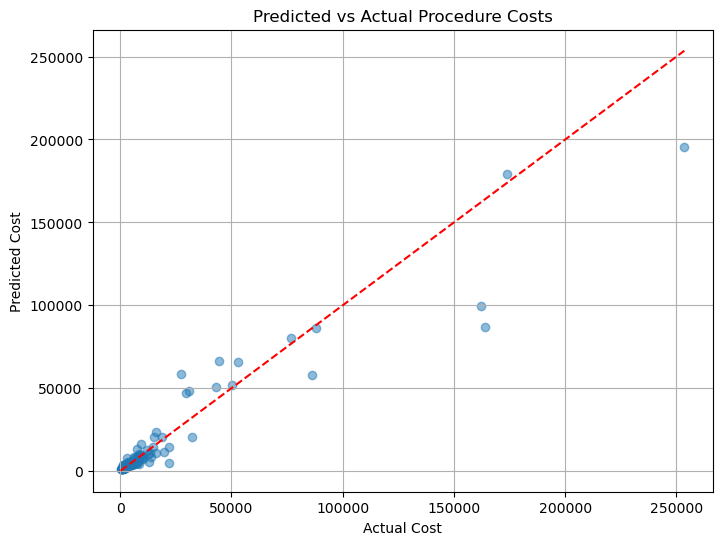

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Predicted vs Actual Procedure Costs")
plt.grid(True)
plt.show()


In [28]:
from sklearn.metrics import mean_absolute_error

# Baseline: always predict the average of the training cost
baseline_pred = [y_train.mean()] * len(y_test)

# Calculate MAE for baseline
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print(f"📉 Baseline MAE: €{baseline_mae:,.2f}")


📉 Baseline MAE: €21,230.76


In [30]:
baseline_pred = [y_train.mean()] * len(y_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print(baseline_mae)

21230.760596036704


In [97]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Load dataset
df = pd.read_csv("cleaned_data.csv", low_memory=False)

# Keep only selected columns
selected_cols = [
    'specialty',
    'procedure_name',
    'material_name',
    'material_type',
    'material_subtype',
    'manufacturer',
    'surgeon_name',
    'surgeon_specific_action',  # Keep it if clean enough
    'material_price'
]

# Drop rows where price is missing
df = df[selected_cols].dropna(subset=['material_price'])

# Fill missing values in categorical fields with "unknown"
categorical_cols = [col for col in selected_cols if col != 'material_price']
df[categorical_cols] = df[categorical_cols].fillna('unknown')

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(df[categorical_cols])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical_cols))

# Define features and target
X = X_cat_df
y = df['material_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  # Calculate MSE

print(f" Mean Absolute Error: {mae:.2f}")
print(f" R² Score: {r2:.2f}")
print(f" Mean Squared Error: {mse:.2f}")  # Display MSE


✅ Mean Absolute Error: 17.49
✅ R² Score: 0.93
✅ Mean Squared Error: 769.58


In [38]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# True values
y_true = y_test_proc

# Baseline: predict the same mean value for all
baseline_pred = np.full_like(y_true, y_train_proc.mean())

# Evaluate baseline
baseline_mae = mean_absolute_error(y_true, baseline_pred)
baseline_r2 = r2_score(y_true, baseline_pred)

print(f"📉 Baseline Mean Absolute Error: {baseline_mae:.2f}")
print(f"📉 Baseline R² Score: {baseline_r2:.2f}")


📉 Baseline Mean Absolute Error: 21230.76
📉 Baseline R² Score: -0.00


In [91]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.metrics import mean_squared_error

# Step 1: Load full dataset (with material-level data)
df = pd.read_csv("cleaned_data.csv", low_memory=False)

# Step 2: Clean and prepare material-level features
# Combine surgeon name and surname
df['surgeon_full_name'] = df['surgeon_name'].str.strip() + ' ' + df['surgeon_surname'].str.strip()

# Define relevant columns
material_features = [
    'specialty',
    'procedure_id',
    'procedure_name',
    'material_name',
    'surgeon_full_name',
    'surgeon_specific_action',
    'material_price'
]

df = df[material_features].dropna(subset=['material_price'])

# Fill missing categorical values
cat_cols = [col for col in material_features if col != 'material_price']
df[cat_cols] = df[cat_cols].fillna('unknown')

# Step 3: Train a material-level price prediction model (Model 2)
encoder_mat = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_mat = encoder_mat.fit_transform(df[cat_cols])
y_mat = df['material_price'].values.astype('float32')

X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(X_mat, y_mat, test_size=0.2, random_state=42)

model_mat = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_mat.fit(X_train_mat, y_train_mat)

# Predict material prices (optional: replace missing prices)
df['predicted_price'] = model_mat.predict(encoder_mat.transform(df[cat_cols]))

# Step 4: Aggregate to procedure level for Model 1
agg_df = df.groupby(['procedure_id', 'procedure_name']).agg({
    'predicted_price': 'sum',
    'material_price': 'sum',
    'material_name': 'count',
    'surgeon_full_name': 'first',
    'specialty': 'first'
}).reset_index().rename(columns={
    'material_name': 'material_count',
    'predicted_price': 'predicted_total_price',
    'material_price': 'true_total_price'
})

# Step 5: Train procedure-level model (Model 1) to predict total cost
procedure_cat_cols = ['procedure_name', 'surgeon_full_name', 'specialty']
agg_df[procedure_cat_cols] = agg_df[procedure_cat_cols].fillna('unknown')

encoder_proc = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_proc_cat = encoder_proc.fit_transform(agg_df[procedure_cat_cols])
X_proc_num = agg_df[['material_count']].values.astype('float32')
X_proc = hstack([X_proc_cat, X_proc_num])
y_proc = agg_df['true_total_price'].values.astype('float32')

X_train_proc, X_test_proc, y_train_proc, y_test_proc = train_test_split(X_proc, y_proc, test_size=0.2, random_state=42)

model_proc = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_proc.fit(X_train_proc, y_train_proc)

# Step 6: Evaluate the procedure-level model
y_pred_proc = model_proc.predict(X_test_proc)

mae_proc = mean_absolute_error(y_test_proc, y_pred_proc)
r2_proc = r2_score(y_test_proc, y_pred_proc)
mse_proc = mean_squared_error(y_test_proc, y_pred_proc)

print(f"\n Procedure-Level Model Results:")
print(f" Mean Absolute Error: {mae_proc:.2f}")
print(f" R² Score: {r2_proc:.2f}")
print(f" Mean Squared Error: {mse_proc:.2f}")


🎯 Procedure-Level Model Results:
✅ Mean Absolute Error: 5158.46
✅ R² Score: 0.89

🎯 Procedure-Level Model Results:
✅ Mean Absolute Error: 5158.46
✅ R² Score: 0.89
📐 Mean Squared Error: 173583344.00


In [85]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_proc = np.sqrt(mse_proc)
print(f" Root Mean Squared Error: {rmse_proc:.2f}")


✅ Root Mean Squared Error: 13175.10


In [67]:
df.to_csv("material_level_with_predictions.csv", index=False)


In [69]:
agg_df.to_csv("procedure_level_aggregated.csv", index=False)


In [71]:
results_df = pd.DataFrame({
    'actual_cost': y_test_proc,
    'predicted_cost': y_pred_proc
})
results_df.to_csv("procedure_level_predictions_vs_actual.csv", index=False)


In [73]:
material_results = df[['procedure_id', 'procedure_name', 'material_name', 'material_price', 'predicted_price']]
material_results.to_csv("material_level_predictions_vs_actual.csv", index=False)


In [75]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define your base model
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the grid of parameters to test
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1  # use all processors
)

# Fit to training data
grid_search.fit(X_train_proc, y_train_proc)

# Best model and score
print(" Best parameters:", grid_search.best_params_)
print(" Best MAE (neg):", -grid_search.best_score_)

# Use the best model
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
🔍 Best MAE (neg): 3725.9693359375


In [79]:
import pandas as pd

summary = pd.DataFrame({
    "Step": ["Material-Level Model", "Aggregation", "Procedure-Level Model"],
    "Description": [
        "Predict cost of each material",
        "Group by procedure to calculate total cost",
        "Predict total procedure cost"
    ],
    "Output": ["predicted_price", "true_total_price", "predicted_total_price"]
})

summary


,Step,Description,Output
0,Material-Level Model,Predict cost of each material,predicted_price
1,Aggregation,Group by procedure to calculate total cost,true_total_price
2,Procedure-Level Model,Predict total procedure cost,predicted_total_price


In [89]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# Step 1: Load full dataset (with material-level data)
df = pd.read_csv("cleaned_data.csv", low_memory=False)

# Step 2: Clean and prepare material-level features
df['surgeon_full_name'] = df['surgeon_name'].str.strip() + ' ' + df['surgeon_surname'].str.strip()

material_features = [
    'specialty',
    'procedure_id',
    'procedure_name',
    'material_name',
    'surgeon_full_name',
    'surgeon_specific_action',
    'material_price'
]

df = df[material_features].dropna(subset=['material_price'])

# Fill missing categorical values
cat_cols = [col for col in material_features if col != 'material_price']
df[cat_cols] = df[cat_cols].fillna('unknown')

# Step 3: Train a material-level price prediction model (Model 2)
encoder_mat = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_mat = encoder_mat.fit_transform(df[cat_cols])
y_mat = df['material_price'].values.astype('float32')

X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(X_mat, y_mat, test_size=0.2, random_state=42)

model_mat = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_mat.fit(X_train_mat, y_train_mat)

df['predicted_price'] = model_mat.predict(encoder_mat.transform(df[cat_cols]))

# Step 4: Aggregate to procedure level for Model 1
agg_df = df.groupby(['procedure_id', 'procedure_name']).agg({
    'predicted_price': 'sum',
    'material_price': 'sum',
    'material_name': 'count',
    'surgeon_full_name': 'first',
    'specialty': 'first'
}).reset_index().rename(columns={
    'material_name': 'material_count',
    'predicted_price': 'predicted_total_price',
    'material_price': 'true_total_price'
})

# Step 5: Train procedure-level model (Model 1) to predict total cost
procedure_cat_cols = ['procedure_name', 'surgeon_full_name', 'specialty']
agg_df[procedure_cat_cols] = agg_df[procedure_cat_cols].fillna('unknown')

encoder_proc = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_proc_cat = encoder_proc.fit_transform(agg_df[procedure_cat_cols])
X_proc_num = agg_df[['material_count']].values.astype('float32')
X_proc = hstack([X_proc_cat, X_proc_num])
y_proc = agg_df['true_total_price'].values.astype('float32')

X_train_proc, X_test_proc, y_train_proc, y_test_proc = train_test_split(X_proc, y_proc, test_size=0.2, random_state=42)

model_proc = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_proc.fit(X_train_proc, y_train_proc)

# Step 6: Evaluate the procedure-level model
y_pred_proc = model_proc.predict(X_test_proc)
mae_proc = mean_absolute_error(y_test_proc, y_pred_proc)
r2_proc = r2_score(y_test_proc, y_pred_proc)
mse_proc = mean_squared_error(y_test_proc, y_pred_proc)

print(f"\n Procedure-Level Model Results:")
print(f" Mean Absolute Error: {mae_proc:.2f}")
print(f" R² Score: {r2_proc:.2f}")
print(f" Mean Squared Error: {mse_proc:.2f}")



🎯 Procedure-Level Model Results:
✅ Mean Absolute Error: 5158.46
✅ R² Score: 0.89
✅ Mean Squared Error: 173583344.00


In [93]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import numpy as np

# Step 1: Load full dataset (with material-level data)
df = pd.read_csv("cleaned_data.csv", low_memory=False)

# Step 2: Clean and prepare material-level features
# Combine surgeon name and surname
df['surgeon_full_name'] = df['surgeon_name'].str.strip() + ' ' + df['surgeon_surname'].str.strip()

# Define relevant columns
material_features = [
    'specialty',
    'procedure_id',
    'procedure_name',
    'material_name',
    'surgeon_full_name',
    'surgeon_specific_action',
    'material_price'
]

df = df[material_features].dropna(subset=['material_price'])

# Fill missing categorical values
cat_cols = [col for col in material_features if col != 'material_price']
df[cat_cols] = df[cat_cols].fillna('unknown')

# Step 3: Train a material-level price prediction model (Model 2)
encoder_mat = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_mat = encoder_mat.fit_transform(df[cat_cols])
y_mat = df['material_price'].values.astype('float32')

X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(X_mat, y_mat, test_size=0.2, random_state=42)

model_mat = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_mat.fit(X_train_mat, y_train_mat)

# Evaluate material-level model
y_pred_mat = model_mat.predict(X_test_mat)
mae_mat = mean_absolute_error(y_test_mat, y_pred_mat)
mse_mat = mean_squared_error(y_test_mat, y_pred_mat)
rmse_mat = np.sqrt(mse_mat)
r2_mat = r2_score(y_test_mat, y_pred_mat)

print(f"\n🔬 Material-Level Model Results:")
print(f" MAE: {mae_mat:.2f}")
print(f" MSE: {mse_mat:.2f}")
print(f" RMSE: {rmse_mat:.2f}")
print(f" R² Score: {r2_mat:.2f}")

# Predict material prices (optional: replace missing prices)
df['predicted_price'] = model_mat.predict(encoder_mat.transform(df[cat_cols]))

# Step 4: Aggregate to procedure level for Model 1
agg_df = df.groupby(['procedure_id', 'procedure_name']).agg({
    'predicted_price': 'sum',
    'material_price': 'sum',
    'material_name': 'count',
    'surgeon_full_name': 'first',
    'specialty': 'first'
}).reset_index().rename(columns={
    'material_name': 'material_count',
    'predicted_price': 'predicted_total_price',
    'material_price': 'true_total_price'
})

# Step 5: Train procedure-level model (Model 1) to predict total cost
procedure_cat_cols = ['procedure_name', 'surgeon_full_name', 'specialty']
agg_df[procedure_cat_cols] = agg_df[procedure_cat_cols].fillna('unknown')

encoder_proc = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_proc_cat = encoder_proc.fit_transform(agg_df[procedure_cat_cols])
X_proc_num = agg_df[['material_count']].values.astype('float32')
X_proc = hstack([X_proc_cat, X_proc_num])
y_proc = agg_df['true_total_price'].values.astype('float32')

X_train_proc, X_test_proc, y_train_proc, y_test_proc = train_test_split(X_proc, y_proc, test_size=0.2, random_state=42)

model_proc = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model_proc.fit(X_train_proc, y_train_proc)

# Step 6: Evaluate the procedure-level model
y_pred_proc = model_proc.predict(X_test_proc)
mae_proc = mean_absolute_error(y_test_proc, y_pred_proc)
r2_proc = r2_score(y_test_proc, y_pred_proc)
mse_proc = mean_squared_error(y_test_proc, y_pred_proc)
rmse_proc = np.sqrt(mse_proc)

print(f"\n🎯 Procedure-Level Model Results:")
print(f" Mean Absolute Error: {mae_proc:.2f}")
print(f" R² Score: {r2_proc:.2f}")
print(f" MSE: {mse_proc:.2f}")
print(f" RMSE: {rmse_proc:.2f}")



🔬 Material-Level Model Results:
✅ MAE: 50.76
📐 MSE: 5066.65
📉 RMSE: 71.18
✅ R² Score: 0.54

🎯 Procedure-Level Model Results:
✅ Mean Absolute Error: 5158.46
✅ R² Score: 0.89
📐 MSE: 173583344.00
📉 RMSE: 13175.10
